<div id="toc"></div>

# Forward modeling of the emission spectrum using VALD3

Tako Ishikawa, Hajime Kawahara
last update: 2021/12/02   
created: : 2021/07/20

<!-- 
written with reference to :  
"exojax/examples/tutorial/Forward\ modeling.ipynb"  
"ghR/exojax_0/examples/testlines/line_strength_CO.py"  

cd ~/work

-->

This example provides how to use VALD3 for forward modeling of the emission spectrum.

In [1]:
from exojax.spec.rtransfer import nugrid
from exojax.spec.rtransfer import pressure_layer 
from exojax.spec import moldb, molinfo, contdb
from exojax.spec import atomll
from exojax.spec.exomol import gamma_exomol
from exojax.spec import SijT, doppler_sigma
from exojax.spec import planck
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import vmap, jit
import numpy as np

## T-P profile 

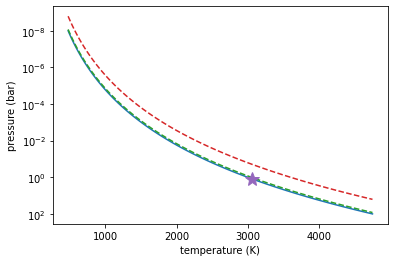

In [2]:
#Assume ATMOSPHERE                                                                     
NP=100
T0=3000. #10000. #3000. #1295.0 #K
Parr, dParr, k=pressure_layer(NP=NP)
H_He_HH_VMR = [0.0, 0.16, 0.84] #typical quasi-"solar-fraction"
Tarr = T0*(Parr)**0.1

PH = Parr* H_He_HH_VMR[0]
PHe = Parr* H_He_HH_VMR[1]
PHH = Parr* H_He_HH_VMR[2]

fig=plt.figure(figsize=(6,4))
plt.plot(Tarr,Parr)
plt.plot(Tarr, PH, '--'); plt.plot(Tarr, PHH, '--'); plt.plot(Tarr, PHe, '--')
plt.plot(Tarr[80],Parr[80], marker='*', markersize=15)
plt.yscale("log")
plt.xlabel("temperature (K)")
plt.ylabel("pressure (bar)")
plt.gca().invert_yaxis()
plt.show()

## Wavenumber

In [5]:
#We set a wavenumber grid using nugrid.
nus,wav,res = nugrid(10380, 10430, 4500, unit="AA") 

xsmode assumes ESLOG: mode= lpf


## Load a database of atomic lines from VALD3

In [6]:
#Loading a database of a few atomic lines from VALD3  #BU: CO and CIA (H2-H2)... 
"""
    valdlines:  fullpath to the input line list obtained from VALD3 (http://vald.astro.uu.se/):
            VALD data access is free but requires registration through the Contact form (http://vald.astro.uu.se/~vald/php/vald.php?docpage=contact.html). After the registration, you can login and choose the "Extract Element" mode.
        For a example in this notebook, the request form of "Extract All" mode was filled as:
          Extract All
            Starting wavelength :    10380
            Ending wavelength :    10430
            Extraction format :    Long format
            Retrieve data via :    FTP
            (Hyperfine structure:    N/A)
            (Require lines to have a known value of :    N/A)
            Linelist configuration :    Default
            Unit selection:    Energy unit: eV - Medium: vacuum - Wavelength unit: angstrom - VdW syntax: default
        Please assign the fullpath of the output file sent by VALD ([user_name_at_VALD].[request_number_at_VALD].gz;  "vald2600.gz" in the code below) to the variable "valdlines".
        Note that the number of spectral lines that can be extracted in a single request is limited to 1000 in VALD (https://www.astro.uu.se/valdwiki/Restrictions%20on%20extraction%20size).
"""

valdlines = 'HiroyukiIshikawa.4214450.gz'
adbFe = moldb.AdbVald(valdlines, nus)


Reading VALD file


/home/kawahara/anaconda3/lib/python3.8/site-packages/exojax-0.8.1-py3.8.egg/exojax/spec/moldb.py:824: RuntimeWarning: divide by zero encountered in log
  self.logsij0=jnp.array(np.log(self.Sij0))


## Relative partition function

In [8]:
#Computing the relative partition function,

qt_284=vmap(adbFe.QT_interp_284)(Tarr)
qt = np.zeros([len(adbFe.QTmask), len(Tarr)])
#qt = np.empty_like(adbFe.QTmask, dtype='object')
for i, mask in enumerate(adbFe.QTmask):
    qt[i] = qt_284[:,mask]  #e.g., qt_284[:,76] #Fe I
qt = jnp.array(qt)


(954, 100)


## Pressure and Natural broadenings (Lorentzian width)  


In [9]:
gammaLMP = jit(vmap(atomll.gamma_vald3,(0,0,0,0,None,None,None,None,None,None,None,None,None,None,None)))\
        (Tarr, PH, PHH, PHe, adbFe.ielem, adbFe.iion, \
                adbFe.dev_nu_lines, adbFe.elower, adbFe.eupper, adbFe.atomicmass, adbFe.ionE, \
                adbFe.gamRad, adbFe.gamSta, adbFe.vdWdamp, 1.0)  

## Doppler broadening

In [10]:
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
    (adbFe.nu_lines, Tarr, adbFe.atomicmass)

## Line strength

In [11]:
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qt.T)

## nu matrix

In [13]:
from exojax.spec.initspec import init_lpf
numatrix=init_lpf(adbFe.nu_lines,nus)

## Compute dtau for each atomic species (or ion) in a SEPARATE array

Separate species

In [15]:
def get_unique_list(seq):
    seen = []
    return [x for x in seq if x not in seen and not seen.append(x)]

uspecies = get_unique_list(jnp.vstack([adbFe.ielem, adbFe.iion]).T.tolist())

Set the stellar/planetary parameters

In [17]:
#Parameters of Objects
Rp = 0.36*10 #R_sun*10    #Rp=0.88 #[R_jup]
Mp = 0.37*1e3 #M_sun*1e3    #Mp=33.2 #[M_jup]
g = 2478.57730044555*Mp/Rp**2
print('logg: '+str(np.log10(g))) #check

logg: 4.849799190511717


Calculate delta tau

In [30]:
#For now, ASSUME all atoms exist as neutral atoms. 
#In fact, we can't ignore the effect of molecular formation e.g. TiO (」゜□゜)」

from exojax.spec.lpf import xsmatrix
from exojax.spec.rtransfer import dtauM

from exojax.spec.atomllapi import load_atomicdata
ipccd = load_atomicdata()
ieleml = jnp.array(ipccd['ielem'])
Narr = jnp.array(10**(12+ipccd['solarA'])) #number density
massarr = jnp.array(ipccd['mass']) #mass of each neutral atom
Nmassarr = Narr * massarr #mass of each neutral species

dtaual = np.zeros([len(uspecies), len(Tarr), len(nus)])
maskl = np.zeros(len(uspecies)).tolist()

for i, sp in enumerate(uspecies):
    maskl[i] = (adbFe.ielem==sp[0])\
                    *(adbFe.iion==sp[1])
    
    #Currently not dealing with ionized species yet... (#tako %\\\\20210814)
    if sp[1] > 1:
        continue
     
    #Providing numatrix, thermal broadening, gamma, and line strength, we can compute cross section.  
    xsm=xsmatrix(numatrix[maskl[i]], sigmaDM.T[maskl[i]].T, gammaLMP.T[maskl[i]].T, SijM.T[maskl[i]].T)
    #Computing delta tau for atomic absorption
    MMR_X_I = Nmassarr[ jnp.where(ieleml==sp[0])[0][0] ] / jnp.sum(Nmassarr)
    mass_X_I = massarr[ jnp.where(ieleml==sp[0])[0][0] ] #MMR and mass of neutral atom X (if all elemental species are neutral)
    dtaual[i] = dtauM(dParr, xsm, MMR_X_I*np.ones_like(Tarr), mass_X_I, g)
    



compute delta tau for CIA

In [31]:
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia', nus)

from exojax.spec.rtransfer import dtauCIA
mmw=2.33 #mean molecular weight
mmrH2=0.74
molmassH2=molinfo.molmass("H2")
vmrH2=(mmrH2*mmw/molmassH2) #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

H2-H2


## Total delta tau

In [32]:
dtau = np.sum(dtaual, axis=0) + dtaucH2H2

## Plot contribution function

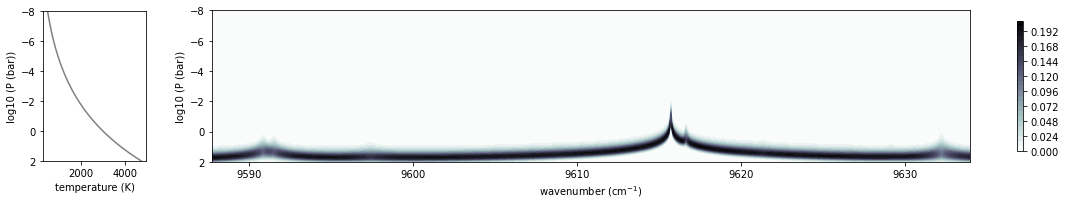

In [34]:
from exojax.plot.atmplot import plotcf
plotcf(nus,dtau,Tarr,Parr,dParr)
plt.show()

## Radiative transfer

In [35]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr, nus)
F0=rtrun(dtau, sourcef)

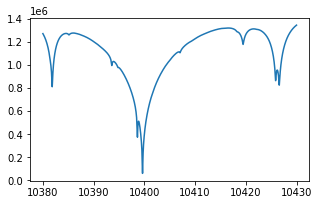

In [37]:
fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1],F0)
plt.show()

In [42]:
#Check line species
print(np.unique(adbFe.ielem))

[10 12 13 14 17 18 20 21 22 24 25 26 27 28 29 32 38 59 64 65 66 70 90]


## Rotational & instrumental broadening

In [43]:
from exojax.spec import response
from exojax.utils.constants import c #[km/s]
import jax.numpy as jnp

wavd=jnp.linspace(10380, 10450,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

R=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*R) #IP sigma need check 

Frot=response.rigidrot(nus,F0,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

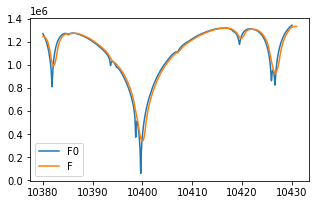

In [44]:
fig=plt.figure(figsize=(5, 3))
plt.plot(wav[::-1],F0, label='F0')
plt.plot(wavd[::-1],F, label='F')
plt.legend()
plt.show()